In [1]:
import torch
from transformers import AdamW
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from transformers import DebertaV2Tokenizer, DebertaV2Model

In [2]:
#tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-v2-xlarge')
model = DebertaV2Model.from_pretrained('microsoft/deberta-v2-xxlarge') 

Some weights of the model checkpoint at microsoft/deberta-v2-xxlarge were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Assessing Sparcity

### Flattening weights for each layer

In [3]:
i = 0
encoder = "encoder.layer."
d = {}
for i in range(48):
  encoder_check = encoder+'{}.'.format(i)
  d[encoder_check] = []

KEYS = list(d.keys())
for name, param in model.named_parameters():
  a = (torch.flatten(param)).tolist()
  match_list = map(name.startswith, KEYS)
  for ind, elem in enumerate(match_list):
    if elem:
      match = KEYS[ind]
      a = (torch.flatten(param)).tolist()
      d[match].extend(a)
      break

### Plotting percentages

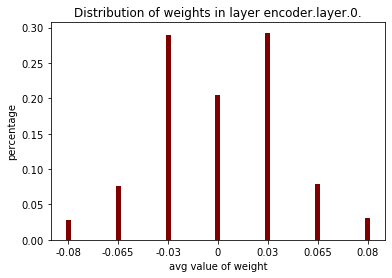

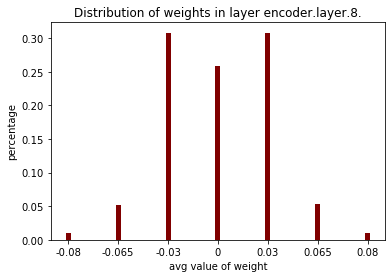

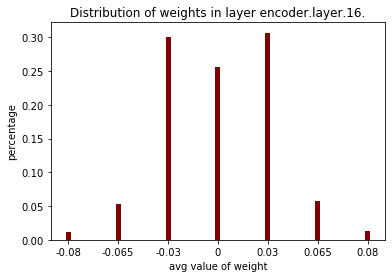

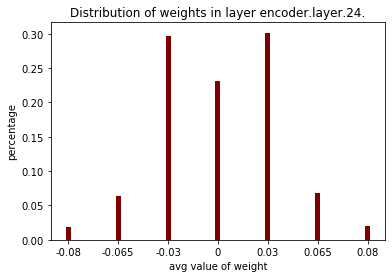

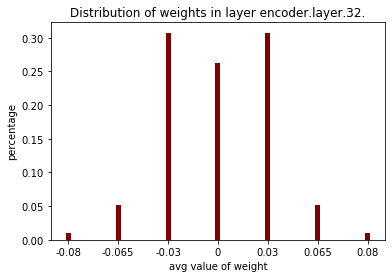

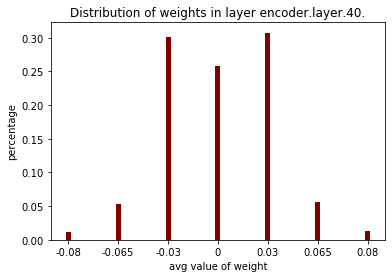

In [4]:
import matplotlib.pyplot as plt

i = 0
for key, val in d.items():
    if i%8 != 0:
        i+=1
        continue
    a = val
    to_plot_dict = {}
    to_plot_dict['-0.08'] = 0
    to_plot_dict['-0.065'] = 0
    to_plot_dict['-0.03'] = 0
    to_plot_dict['0'] = 0
    to_plot_dict['0.03'] = 0
    to_plot_dict['0.065'] = 0
    to_plot_dict['0.08'] = 0
    

    for elem in a:
        if elem <= -.08:
            to_plot_dict['-0.08'] += 1
        elif elem <= -.05 and elem > -.08:
            to_plot_dict['-0.065'] += 1
        elif elem <= -.01 and elem > -0.05:
            to_plot_dict['-0.03'] += 1
        elif elem <= .01 and elem > -0.01:
            to_plot_dict['0'] += 1
        elif elem <= .05 and elem > 0.01:
            to_plot_dict['0.03'] += 1
        elif elem <= .08 and elem > 0.05:
            to_plot_dict['0.065'] += 1
        elif elem >= 0.08:
            to_plot_dict['0.08'] += 1

    x = list(to_plot_dict.keys())
    counts = list(to_plot_dict.values())
    y = [ind/len(a) for ind in counts]
    plt.figure()
    plt.bar(x, y, color ='maroon',
            width = 0.1)
    plt.xlabel("avg value of weight")
    plt.ylabel("percentage")
    plt.title("Distribution of weights in layer {}".format(key))
    plt.show()
    i+=1

### Plotting Density

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
i=0
for key, val in d.items():
    if i%8==0:
        plt.figure()
        plt.hist(val, density = True, bins = 1000, range= (-.25, .25))
        plt.gca().set(title='Density histogram for {}'.format(key), ylabel='Frequency')
        plt.show()
    i+=1

## Pruning

In [30]:
def prune_layers(ratio):
    for i in range(48):
        list = ['encoder.layer.{}.attention.self.query_proj'.format(i),
                        'encoder.layer.{}.attention.self.key_proj'.format(i),
                        'encoder.layer.{}.attention.self.value_proj'.format(i),
                        'encoder.layer.{}.attention.output.dense'.format(i),
                        'encoder.layer.{}.attention.output.LayerNorm'.format(i),
                        'encoder.layer.{}.intermediate.dense'.format(i),
                        'encoder.layer.{}.output.dense'.format(i),
                        'encoder.layer.{}.output.LayerNorm'.format(i)]
                        
        for name,module in model.named_modules():
            if name in list:
                prune.l1_unstructured(module, name='weight', amount= ratio)
                prune.remove(module, 'weight')

In [ ]:
model = DebertaV2Model.from_pretrained('microsoft/deberta-v2-xxlarge') 
ratio = 0.2
prune_layers(ratio)